In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))
print(X_motion.shape)
print(Y_motion.shape)

(13407, 28)
(13407, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where RL swings
idxs = np.where(X_motion[:, 23] == 1)[0]
X_motion_RL_swinging = X_motion[idxs]
Y_motion_RL_swinging = Y_motion[idxs]

## Predict RL foot -> x

In [8]:
X_motion_RL_swinging[0, :]

array([ 1.00000001e-01,  0.00000000e+00,  0.00000000e+00,  6.56125231e-02,
        1.26074604e-01,  1.15141802e-02,  1.44907966e-04,  2.22762429e-02,
       -3.64215359e-03,  2.45064076e-01,  1.73711652e-01, -4.29870702e-01,
        2.28035357e-01, -1.87407597e-01, -4.30159975e-01, -2.69479531e-01,
        1.37242626e-01, -4.29456144e-01, -2.41380165e-01, -1.60313309e-01,
       -4.29952199e-01,  0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  1.00000001e-01,  0.00000000e+00,  0.00000000e+00])

In [9]:
X_motion_RL_swinging[0, :]

array([ 1.00000001e-01,  0.00000000e+00,  0.00000000e+00,  6.56125231e-02,
        1.26074604e-01,  1.15141802e-02,  1.44907966e-04,  2.22762429e-02,
       -3.64215359e-03,  2.45064076e-01,  1.73711652e-01, -4.29870702e-01,
        2.28035357e-01, -1.87407597e-01, -4.30159975e-01, -2.69479531e-01,
        1.37242626e-01, -4.29456144e-01, -2.41380165e-01, -1.60313309e-01,
       -4.29952199e-01,  0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  1.00000001e-01,  0.00000000e+00,  0.00000000e+00])

### Linear Regression

In [10]:
# Input
X = np.hstack((X_motion_RL_swinging[:, :3], # prev velocity command
               X_motion_RL_swinging[:, -3:], # commanded velocity command
               X_motion_RL_swinging[:, 9:11], # FL (x,y) position
               X_motion_RL_swinging[:, 12:14], # FR (x,y) position
               X_motion_RL_swinging[:, 15:17], # RL (x,y) position
               X_motion_RL_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_RL_swinging[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rl_relative_swinging_x = LinearRegression()

# Fit the model
model_rl_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_rl_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9951215536092632
RMSE:  0.003642732366316221
The lowest error is:  1.507862810737337e-06
The highest error is:  0.03506327438001927
The avg. error is:  0.002235454485182805


In [11]:
model_rl_relative_swinging_x.coef_

array([[ 4.63327619e-03, -8.32667268e-17, -1.80411242e-16,
         2.15615897e-01, -6.93889390e-17,  1.04083409e-16,
        -1.69104289e-01,  3.40228644e-01, -4.66905985e-02,
        -2.20296893e-01, -2.40169435e-01,  1.37081730e-03,
         1.74835255e-01,  1.36837547e-01]])

In [12]:
model_rl_relative_swinging_x.intercept_

array([-0.04426559])

Text(0, 0.5, 'Predictions')

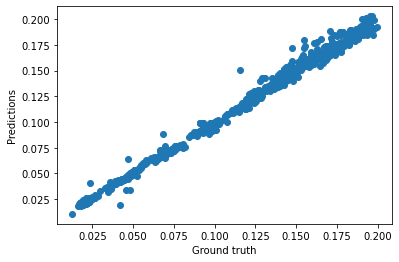

In [13]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [14]:
#%store model_rl_relative_swinging_x

In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [16]:
# Save model
#joblib.dump(model_rl_relative_swinging_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rl_relative_swinging_x.sav")

### Predict RL foot -> y

In [17]:
# Input
X = np.hstack((X_motion_RL_swinging[:, :3], # prev velocity command
               X_motion_RL_swinging[:, -3:], # commanded velocity command
               X_motion_RL_swinging[:, 9:11], # FL (x,y) position
               X_motion_RL_swinging[:, 12:14], # FR (x,y) position
               X_motion_RL_swinging[:, 15:17], # RL (x,y) position
               X_motion_RL_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_RL_swinging[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rl_relative_swinging_y = LinearRegression()

# Fit the model
model_rl_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_rl_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.47419122919445145
RMSE:  0.004666553215763124
The lowest error is:  1.8759537701029672e-07
The highest error is:  0.02402018465188105
The avg. error is:  0.0032257814068493186


In [18]:
model_rl_relative_swinging_y.coef_

array([[-2.53274287e-03,  3.81639165e-17,  1.66533454e-16,
        -8.93581944e-03,  8.32667268e-17, -5.55111512e-17,
        -3.61099329e-03, -1.83462971e-01, -3.79340632e-01,
         3.46523202e-01,  2.69529509e-01, -5.31579248e-01,
         2.31191491e-01,  4.77945289e-02]])

In [19]:
model_rl_relative_swinging_y.intercept_

array([0.3971966])

Text(0, 0.5, 'Predictions')

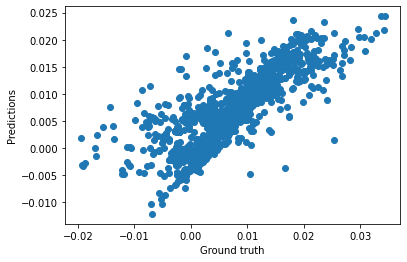

In [20]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [21]:
#%store model_rl_relative_swinging_y

In [74]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [75]:
# Save model
#joblib.dump(model_rl_relative_swinging_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rl_relative_swinging_y.sav")